In [1]:
# Uncommon Install

%pip install pytorch-msssim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Dominik Danda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import random
import copy
from PIL import Image
from scipy.stats import pearsonr
from pytorch_msssim import ssim, ms_ssim
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset
from tqdm import tqdm

In [3]:
# Global Parameters

data_ratio = 0.25 # How much of the full dataset to use for training.
batch_size = 64 # Number of images to process at once.
learning_rate = 0.0001 # Learning rate for the optimizer.
num_epochs = 250 # Number of epochs to train for.
loss_weights = [1, 1, 0.07, 0] # Weights for each metric: [MSE, SSIM, Sobel, Fourier]
label_length = 16 # Number of labels for training.


In [4]:
# Convolutional Generator Architecture

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class generator(nn.Module): 
    def __init__(self):
        super(generator,self).__init__()
        #linear layer
        self.fc1 = nn.Linear(label_length,16*16*128)
        
        self.convinv1 = nn.ConvTranspose2d(128,64,kernel_size = 4, stride = 2, padding = 1, bias = True) #128*16*16 -> 64*32*32
        self.convinv2 = nn.ConvTranspose2d(64,64,kernel_size = 4, stride = 2, padding = 1, bias = True) #64*32*32 -> 64*64*64
        self.convinv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias = True) #64*64*64 -> 128*128*32
        self.convpreserve1 = nn.Conv2d(32,32,kernel_size = 5, stride = 1, padding = 2, bias = True) #128*128*32 -> 128*128*32
        self.conv = nn.Conv2d(32,3,kernel_size = 1, stride = 1, padding= 0, bias = True) #128*128*64 -> 128*128*3
    
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = x.view(-1, 128,16,16)
        x = F.leaky_relu(self.convinv1(x))
        x = F.leaky_relu(self.convinv2(x))
        x = F.leaky_relu(self.convinv3(x))
        x = F.leaky_relu(self.convpreserve1(x))
        
        x = self.conv(x)
        
        return x
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [5]:
# Loss Function Definition

class MultiMetricLoss:
    def __init__(self, weights=None):
        # Weights for each metric: [MSE, SSIM, Histogram, Correlation, Sobel, fourier]
        if weights is None:
            self.weights = loss_weights
        else:
            self.weights = weights

    def mse_loss(self, image1, image2):
        return F.mse_loss(image1, image2)*self.weights[0]

    def ssim_loss(self, image1_tensor, image2_tensor):
        ssim_index = ms_ssim(image1_tensor, image2_tensor, data_range=1,win_size=3)
        return (1.0 - ssim_index)*self.weights[1]  # SSIM ranges from 0 (completely different) to 1 (identical)

    def sobel_loss(self, image1, image2):
        # Sobel filters to detect edges (on grayscale version of images)
        sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32)
        sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32)
        sobel_x = sobel_x.view(1, 1, 3, 3).to(image1.device)
        sobel_y = sobel_y.view(1, 1, 3, 3).to(image1.device)

        image1_gray = image1.mean(dim=1, keepdim=True)
        image2_gray = image2.mean(dim=1, keepdim=True)

        edges1_x = F.conv2d(image1_gray, sobel_x, padding=1)
        edges1_y = F.conv2d(image1_gray, sobel_y, padding=1)
        edges1 = torch.sqrt(edges1_x ** 2 + edges1_y ** 2)

        edges2_x = F.conv2d(image2_gray, sobel_x, padding=1)
        edges2_y = F.conv2d(image2_gray, sobel_y, padding=1)
        edges2 = torch.sqrt(edges2_x ** 2 + edges2_y ** 2)

        return F.mse_loss(edges1, edges2)*self.weights[2]

    def fourier_loss(self, image1, image2):
        # Compute the Fourier transform of the images
        image1_fft = torch.fft.fft2(image1)
        image2_fft = torch.fft.fft2(image2)
        # Compute the magnitude of the Fourier transform
        image1_mag = torch.abs(image1_fft)
        image2_mag = torch.abs(image2_fft)
        # Compute the MSE between the magnitudes
        return F.huber_loss(image1_mag, image2_mag)*self.weights[3]

In [6]:
# Dataloader Definition

class JpgDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the JPG images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_files = sorted(os.listdir(root_dir))

        self.labels = []
        with open("celeba/list_attr_celeba.csv", 'r') as f:
            f.readline()
            for i in self.image_files:
                l = f.readline()
                l = l.split(',')
                l.pop(0)
                l[-1] = l[-1][0]
                l = [int(i) for i in l]
                l = torch.tensor(l)
                self.labels.append(l)
        self.root_dir = root_dir
        self.transform = transform
        
        

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")  # Convert image to RGB
        label = self.labels[idx]
        filename = self.image_files[idx]
        if self.transform:
            image = self.transform(image)

        return image, label , filename

# Define your transformations
transform1 = transforms.Compose([

    transforms.ToTensor(),
    transforms.Resize((128,128)),
    transforms.Normalize(mean = [0,0,0], std = [1,1,1])
])

# Path to the directory containing JPG files
root_dir = 'celeba/img_align_celeba/'

# Create the dataset
dataset = JpgDataset(root_dir=root_dir, transform=transform1)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Define the sizes of each subset
train_size = int(data_ratio * len(dataset)) 

# Split the dataset
train_dataset, garbage_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

# Create DataLoaders for each subset
train_dataset = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Training Loop

g = generator()

if torch.cuda.is_available():
  g = g.cuda()

g.weight_init(mean=0.0, std=0.1)

optim = torch.optim.AdamW(g.parameters(), lr = learning_rate, eps=1e-6)
loss_fn = MultiMetricLoss()
epochs = num_epochs

state_dict = []
state_dict.append(g.state_dict())
torch.save(state_dict, 'model_weights/0.pth')
losses = {}
losses['mse'] = []
losses['ssim'] = []
losses['sobel'] = []
losses['fourier'] = []
losses['total'] = []
for e in range(epochs):
    running_loss_total = 0
    running_loss_mse = 0
    running_loss_ssim = 0
    running_loss_sobel = 0
    running_loss_fourier = 0
    
    # Learning rate decay
    if e % 50 == 0 and e != 0:
        for param_group in optim.param_groups:
            param_group['lr'] = param_group['lr'] * 0.75
            print("Learning rate reduced to: ", param_group['lr'])
      
    
    print('Epoch: ', (e + 1), ' of ', epochs)
    print("Epoch Progress: ")
    
    for i,j,l in tqdm(train_dataset, ascii = ' ░▒▓'):
        
        if torch.cuda.is_available():
            i = i.cuda()
            j = j.cuda()
        
        j = j.float()
        k = g(j)
        
        loss = 0
        mse = loss_fn.mse_loss(k,i)
        ssim = loss_fn.ssim_loss(k,i)
        sobel = loss_fn.sobel_loss(k,i)
        fourier = loss_fn.fourier_loss(k,i)
        
        loss += mse
        loss += ssim
        loss += sobel
        loss += fourier
        
        running_loss_total += loss.item()
        running_loss_mse += mse.item()
        running_loss_ssim += ssim.item()
        running_loss_sobel += sobel.item()
        running_loss_fourier += fourier.item()

        
        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(g.parameters(), max_norm=5, foreach=True)
        optim.step()
        
    losses['mse'].append(running_loss_mse/len(train_dataset))
    losses['ssim'].append(running_loss_ssim/len(train_dataset))
    losses['sobel'].append(running_loss_sobel/len(train_dataset))
    losses['fourier'].append(running_loss_fourier/len(train_dataset))
    losses['total'].append(running_loss_total/len(train_dataset))

    print("Loss: " + str(running_loss_total/len(train_dataset)))
    #print("MSE: " + str(running_loss_mse/len(train_dataset)))
    #print("SSIM: " + str(running_loss_ssim/len(train_dataset)))
    #print("Sobel: " + str(running_loss_sobel/len(train_dataset)))
    #print("Fourier: " + str(running_loss_fourier/len(train_dataset)))
    print(" ")
    state_dict.append(copy.deepcopy(g.state_dict()))
    
    # THIS WILL OVERWRITE ANY PREVIOUS WEIGHTS FROM PREVIOUS MODELS, CHANGE THE PATH TO SAVE WEIGHTS FROM DIFFERENT MODELS
    torch.save(state_dict[-1], 'model_weights/' + str(e) + '.pth')

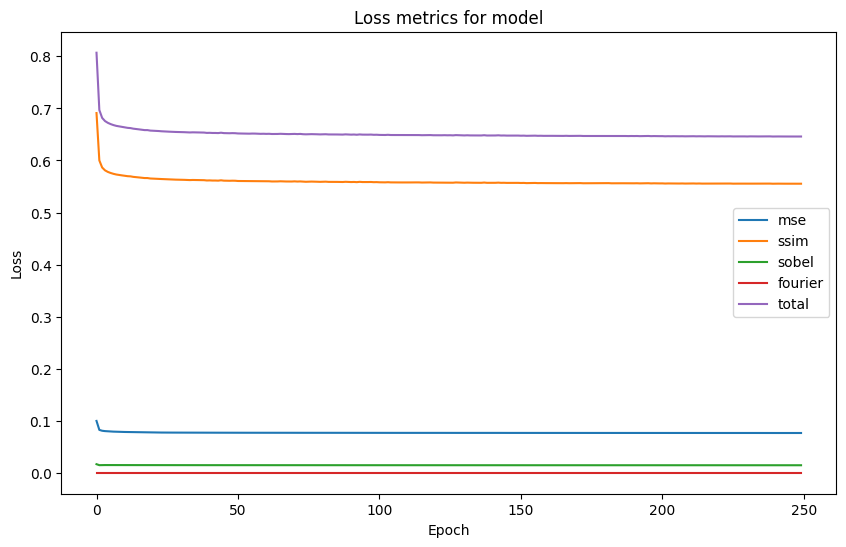

In [ ]:
# Plot the loss metrics

plt.figure(figsize=(10, 6))

for loss_type in losses.keys():
    plt.plot(losses[loss_type])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss metrics for model')

plt.legend(losses.keys())

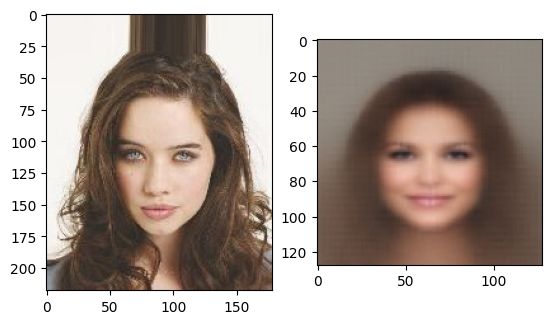

In [ ]:
# Create Comparison Image

# Load the model from the last epoch
model = generator()
model.load_state_dict(state_dict[-1])
name_list = os.listdir('celeba/img_align_celeba/')
filename = random.choice(name_list)
og_img = Image.open('celeba/img_align_celeba/'+filename)

# Display sample original image next to generated image
plt.subplot(1,2,1) 
plt.imshow(og_img)
plt.subplot(1,2,2)
label = dataset.labels[name_list.index(filename)]
label = label.float()
img = model(label)
img = transforms.ToPILImage()(img[0])
plt.imshow(img)

In [ ]:
# Run label though every generator epoch and save the images

gen = generator()

for file in os.listdir('model_weights/'):
    filename = os.fsdecode(file)
    
    gen.load_state_dict(torch.load("model_weights/" + file, map_location=torch.device('cpu')))
    
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig,[0.,0.,1.,1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    img = gen(label)
    img = transforms.ToPILImage()(img[0])
    
    filename = filename.rsplit( ".", 1 )[ 0 ]
    
    #add leading 0s to the filename
    num = filename.zfill(3)
    
    ax.imshow(img ,aspect='auto')
    fig.savefig('gif_photos/' + str(num) + '.png')
    fig.clear()

In [ ]:
# Create a gif from the images

from PIL import Image
from PIL import ImageDraw
import glob

# Create an empty list called images
images = []

# Get the label for the image
label_list = label.squeeze().tolist()
label_list = [int(i) for i in label_list]
print(label_list)

# Get all the images in the 'images for gif' folder
for filename in sorted(glob.glob('gif_photos/*.png')):
    im = Image.open(filename)
    draw = ImageDraw.Draw(im)
    draw.text((10, 10),os.path.basename(filename).rsplit( ".", 1 )[ 0 ],(255,255,255), font_size=32)
    draw.text((10, 432),str(label_list),(255,255,255), font_size=32)
    images.append(im)


last_frame = (len(images)) 

# Create 500 extra copies of the last frame (to make the gif spend longer on the most recent data)
for x in range(0, 50):
    im = images[last_frame-1]
    images.append(im)

# Create 50 extra copies of the first frame (to make the gif spend longer on the first data)
for x in range(0, 50):
    im = images[0]
    images.insert(0,im)

# Save as a GIF   
images[0].save('final_gifs/' + ''.join(map(str, label_list)) + '.gif', save_all=True, append_images=images[1:], optimize=True, duration=50, loop=0)